In [22]:
# Importing necessary libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from access import Access, weights, Datasets
import geopandas as gpd
from shapely import wkt
import access
# Custom functions
from modified_access import *
Access.mod_three_stage_fca = class_mod_three_stage_fca

In [2]:
# Importing data
school_census_df = pd.read_csv("/Users/feliphlvo/Documents/Minerva/Capstone/data/local/school_census.csv",index_col=0)
dem_census_df = pd.read_csv("/Users/feliphlvo/Documents/Minerva/Capstone/data/local/dem_census.csv", index_col=0)

In [5]:
# Only public schools with at least one high school class and regions with at least one high-school aged person
geo_dem_census_df = dem_census_df[dem_census_df["n_people_15to17"] > 0]
geo_school_census_df = school_census_df[(school_census_df["n_classes"] > 0) & (school_census_df["admin_type"] != 4.0)]

In [6]:
# Transforming into geometry
geo_dem_census_df = gpd.GeoDataFrame(geo_dem_census_df, geometry = geo_dem_census_df["geometry"].apply(wkt.loads))
geo_school_census_df = gpd.GeoDataFrame(geo_school_census_df, geometry = geo_school_census_df["geometry"].apply(wkt.loads))

/Users/feliphlvo/opt/anaconda3/envs/cap_env/lib/python3.10/site-packages/geopandas/array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/Users/feliphlvo/opt/anaconda3/envs/cap_env/lib/python3.10/site-packages/geopandas/geodataframe.py:31: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  out = from_shapely(np.asarray(data))


In [7]:
# Importing the distance matric. See Creating Distance Matrix.ipynb
dist_matrix = pd.read_csv("/Users/feliphlvo/Documents/Minerva/Capstone/data/local/dist_matrix.csv", index_col=0)
dist_matrix.head()

,origin,dest,euclidean
0,170025105000002,17010535,13894.563390
1,170030105000001,17004268,1524.518606
2,170030105000001,17002648,10449.349289
3,170030105000002,17004268,1450.603219
4,170030105000002,17002648,10129.682425


In [8]:
# Take subset of geo df with only places in Ribeirão Preto
geo_dem_census_df_sub = geo_dem_census_df[geo_dem_census_df['city_name'] == 'Ribeirão Preto']
geo_school_census_df_sub = geo_school_census_df[geo_school_census_df['city_name'] == 'Ribeirão Preto']

In [9]:
# Creating new column where the supply is the number of classes multiplied by the quality of the school
geo_school_census_df_sub["q_weighted_n_classes"] = geo_school_census_df_sub['n_classes'] * geo_school_census_df_sub['ideb_filled']

/var/folders/v6/m0s_jr6d723809xzpzrvx_340000gn/T/ipykernel_4036/1601004132.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_school_census_df_sub["q_weighted_n_classes"] = geo_school_census_df_sub['n_classes'] * geo_school_census_df_sub['ideb_filled']


In [66]:
# Creating the access object
# See documentation for the Access ibrary here: https://github.com/pysal/access/blob/main/access/access.py
A = Access(
    demand_df=geo_dem_census_df_sub,
    demand_index="sector_id",
    demand_value="n_people_15to17",
    supply_df=geo_school_census_df_sub,
    supply_index="school_id",
    supply_value=["n_classes"]
    )

In [67]:
A.create_euclidean_distance(threshold=16000, centroid_o=True, centroid_d=True)

/Users/feliphlvo/opt/anaconda3/envs/cap_env/lib/python3.10/site-packages/geopandas/array.py:546: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return _unary_geo("centroid", self)
/Users/feliphlvo/opt/anaconda3/envs/cap_env/lib/python3.10/site-packages/geopandas/geoseries.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = from_shapely(s.values)


In [73]:
# Including the quality of the schools in the cost matrix (needed for the calculation)
quality_dict = dict(zip(geo_school_census_df_sub.school_id, geo_school_census_df_sub.ideb_filled))
A.cost_df['quality'] = A.cost_df['dest'].map(quality_dict)

In [74]:
A.cost_df

,euclidean,origin,dest,quality,W3,C,W3C
0,1325.254353,354340205000001,35023826,5.4,0.965484,5.4,5.213612
1,1325.254353,354340205000001,35023826,5.4,0.965484,5.4,5.213612
2,1325.254353,354340205000001,35023826,5.4,0.965484,5.4,5.213612
3,1325.254353,354340205000001,35023826,5.4,0.965484,5.4,5.213612
4,1325.254353,354340205000001,35023826,5.4,0.965484,5.4,5.213612
...,...,...,...,...,...,...,...
220879,12688.059858,354340205000957,35925706,4.2,0.039966,4.2,0.167855
220880,12688.059858,354340205000957,35925706,4.2,0.039966,4.2,0.167855
220881,12688.059858,354340205000957,35925706,4.2,0.039966,4.2,0.167855
220882,12688.059858,354340205000957,35925706,4.2,0.039966,4.2,0.167855


In [70]:
# Defining custom weight functions

gaussian = weights.gaussian(5000)   

# Access metrics to calculate
max_cost = 16000
A.mod_three_stage_fca(name = "mod_3sfca", quality_name = 'Q', quality='quality', weight_fn=gaussian, cost = "euclidean", max_cost = max_cost)
A.three_stage_fca(name = "3sfca", weight_fn=gaussian, cost = "euclidean", max_cost = max_cost)
A.access_df["Q_mod_access"] = A.access_df["mod_3sfca_n_classes"] * A.access_df["Q_n_classes"]
A.access_df

,n_people_15to17,mod_3sfca_n_classes,Q_n_classes,3sfca_n_classes,Q_mod_access
sector_id,,,,,
354340205000001,9.0,0.114542,4.392151,0.115518,0.503086
354340205000002,11.0,0.114677,4.390636,0.115657,0.503506
354340205000003,33.0,0.115632,4.386952,0.116572,0.507272
354340205000004,11.0,0.115440,4.389151,0.116375,0.506683
354340205000005,17.0,0.116005,4.386582,0.116910,0.508865
...,...,...,...,...,...
354340210000026,15.0,0.093890,3.971213,0.093957,0.372858
354340210000027,11.0,0.091850,3.985427,0.092053,0.366063
354340210000028,22.0,0.128318,3.865486,0.126676,0.496013


In [64]:
A = Access(
    demand_df=geo_dem_census_df_sub,
    demand_index="sector_id",
    demand_value="n_people_15to17",
    supply_df=geo_school_census_df_sub,
    supply_index="school_id",
    supply_value=["q_weighted_n_classes"]
    )
A.create_euclidean_distance(threshold=16000, centroid_o=True, centroid_d=True)
A.three_stage_fca(name = "3sfca", weight_fn=gaussian, cost = "euclidean", max_cost = max_cost)


/Users/feliphlvo/opt/anaconda3/envs/cap_env/lib/python3.10/site-packages/geopandas/array.py:546: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return _unary_geo("centroid", self)
/Users/feliphlvo/opt/anaconda3/envs/cap_env/lib/python3.10/site-packages/geopandas/geoseries.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = from_shapely(s.values)


KeyError: 'mod_3sfca_n_classes'

In [71]:
il_map = geo_dem_census_df_sub[["sector_id", "geometry"]].set_index("sector_id").join(A.access_df, how="inner")


def plot(v, il_map = il_map, ax=None, leg=True):

    swap_colors = "raam" in v

    base = il_map.plot(
        v,
        legend=leg,
        figsize=(8, 8),
        cmap="viridis_r" if swap_colors else "viridis",
        markersize=5,
        alpha=0.8,
        #vmin=il_map[v].quantile(0.05),
        #vmax=il_map[v].quantile(0.95),
    )

    base.set_axis_off()

    plt.show()



/Users/feliphlvo/opt/anaconda3/envs/cap_env/lib/python3.10/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/Users/feliphlvo/opt/anaconda3/envs/cap_env/lib/python3.10/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


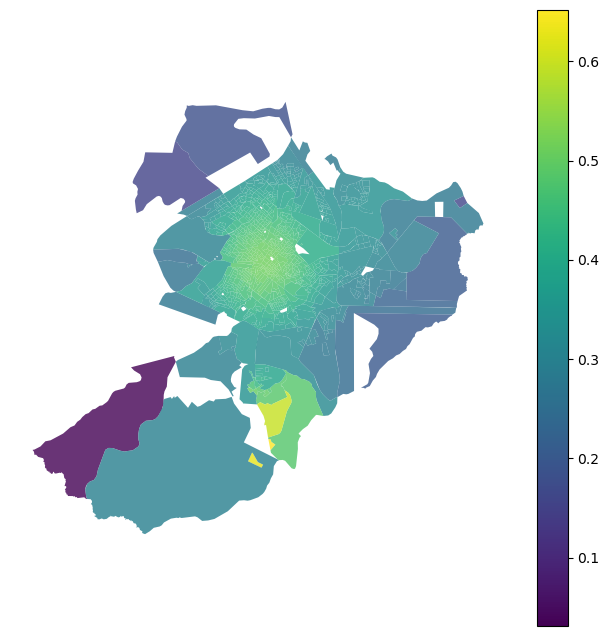

In [72]:
plot("Q_mod_access")

In [65]:
A.access_df

,n_people_15to17,3sfca_q_weighted_n_classes
sector_id,,
354340205000001,9.0,0.507332
354340205000002,11.0,0.507772
354340205000003,33.0,0.511359
354340205000004,11.0,0.510747
354340205000005,17.0,0.512795
...,...,...
354340210000026,15.0,0.372936
354340210000027,11.0,0.366678
354340210000028,22.0,0.489534
